In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

sequenceLen  = 50

df = pd.read_csv('PD_sim_30.csv')

state_mapping = {'OFF': 0, 'ON': 1, 'TroublesomeDYS': 2}
df['STATE'] = df['STATE'].map(state_mapping)

grouped = df.groupby('ID')
sequences = []
for _, group in grouped:
    group = group.sort_values('Time (hour)')
    cols = ['Flow rate (mL/h)', 'LD (mg/L)', 'STATE', 'AGE', 'LBW', 'BMI', 'CRCL']
    seq = group[cols].values
    sequences.append(seq)

data = np.stack(sequences)

features = len(cols)

numerical_indices = [1, 3, 4, 5, 6]  
scaler = MinMaxScaler()
for i in numerical_indices:
    data[:, :, i] = scaler.fit_transform(data[:, :, i].reshape(-1, 1)).reshape(data.shape[0], data.shape[1])

train_data = data[:240]  
val_data = data[240:]   

In [10]:
print(sequences[0])

[[1.50000000e-01 0.00000000e+00 0.00000000e+00 ... 4.10449491e+01
  2.21449890e+01 9.92497165e+01]
 [1.50000000e-01 7.33152300e-03 0.00000000e+00 ... 4.10449491e+01
  2.21449890e+01 9.92497165e+01]
 [1.50000000e-01 7.27536230e-02 0.00000000e+00 ... 4.10449491e+01
  2.21449890e+01 9.92497165e+01]
 ...
 [0.00000000e+00 1.04195000e-04 1.00000000e+00 ... 4.10449491e+01
  2.21449890e+01 9.92497165e+01]
 [0.00000000e+00 1.04190000e-04 0.00000000e+00 ... 4.10449491e+01
  2.21449890e+01 9.92497165e+01]
 [0.00000000e+00 1.04186000e-04 0.00000000e+00 ... 4.10449491e+01
  2.21449890e+01 9.92497165e+01]]


In [11]:
data.shape

(300, 961, 7)

In [12]:
def mask_data(data, mask_prob=0.2):
    masked_data = data.copy()
    mask_2d = np.random.rand(data.shape[0], data.shape[1]) < mask_prob 
    mask = np.stack([mask_2d] * 3, axis=2) #mask.shape = (300, 961, 3)
    # print(mask.shape) 
    
    # masked_data[:, :, 0][mask[:, :, 0]] = -1  # Flow rate
    masked_data[:, :, 1][mask[:, :, 1]] = -1   # LD
    masked_data[:, :, 2][mask[:, :, 2]] = -1  # STATE
    
    return masked_data, mask

In [13]:
mask_data(data)

(array([[[ 1.50000000e-01,  0.00000000e+00,  0.00000000e+00, ...,
           2.08795688e-01,  1.97581764e-01,  4.98216113e-01],
         [ 1.50000000e-01,  1.03703745e-03,  0.00000000e+00, ...,
           2.08795688e-01,  1.97581764e-01,  4.98216113e-01],
         [ 1.50000000e-01, -1.00000000e+00, -1.00000000e+00, ...,
           2.08795688e-01,  1.97581764e-01,  4.98216113e-01],
         ...,
         [ 0.00000000e+00,  1.47382906e-05,  1.00000000e+00, ...,
           2.08795688e-01,  1.97581764e-01,  4.98216113e-01],
         [ 0.00000000e+00,  1.47375834e-05,  0.00000000e+00, ...,
           2.08795688e-01,  1.97581764e-01,  4.98216113e-01],
         [ 0.00000000e+00,  1.47370176e-05,  0.00000000e+00, ...,
           2.08795688e-01,  1.97581764e-01,  4.98216113e-01]],
 
        [[ 1.50000000e-01, -1.00000000e+00, -1.00000000e+00, ...,
           8.47939063e-01,  5.11162726e-01,  3.31150395e-01],
         [ 1.50000000e-01,  3.47622631e-03,  0.00000000e+00, ...,
           8.47939063

In [14]:
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model

inputs = Input(shape=(data.shape[1], features)) # (961, 3)

x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Bidirectional(LSTM(16, return_sequences=True))(x)

# flow_output = TimeDistributed(Dense(1, name='flow_rate'))(x)  
ld_output = TimeDistributed(Dense(1, name='ld'))(x)           
state_output = TimeDistributed(Dense(3, activation='softmax', name='state'))(x)

model = Model(inputs=inputs, outputs=[ld_output, state_output])

2025-03-05 14:39:19.544488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 14:39:19.544591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 14:39:19.545856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 14:39:19.552826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 14:39:20.343432: W tensorflow/compiler/tf2

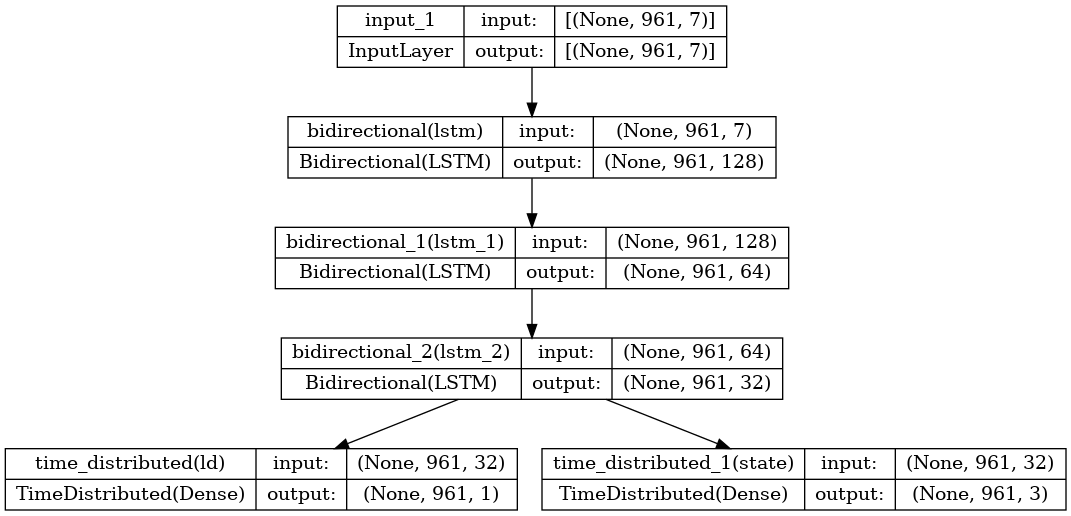

In [15]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
def get_shape(t):
    if isinstance(t, tuple):
        return (len(t), *get_shape(t[0])) if t else ()
    return ()

In [17]:
import tensorflow as tf

mse_loss = tf.keras.losses.MeanSquaredError()
sce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer = tf.keras.optimizers.Adam()


def train_step(inputs, ld_true, state_true, mask_ld, mask_state):
    # print("**")
    with tf.GradientTape() as tape:
        ld_pred, state_pred = model(inputs)
        # print(len(ld_pred), len(state_pred))
        # Note to remember: reduce_sum(...): Sums the masked errors across all elements.
    
        ld_loss = tf.reduce_sum(mask_ld * tf.squeeze(tf.square(ld_true - ld_pred))) / tf.reduce_sum(mask_ld)
        state_loss = tf.reduce_sum(mask_state * sce_loss(state_true, state_pred)) / tf.reduce_sum(mask_state)
        
        total_loss = ld_loss + state_loss
    
    # Note to remember: Computes the gradient of total_loss with respect to all trainable parameters in the model.
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

In [19]:
lossesOverSteps = []

def trainingOverDifferentMasks():
    
    train_masked, train_mask = mask_data(train_data)
    val_masked, val_mask = mask_data(val_data)

    # print(train_mask[0])

    # train_flow_true = train_data[:, :, 0:1]  
    train_ld_true = train_data[:, :, 1:2]    
    train_state_true = train_data[:, :, 2:3]  

    # train_mask_flow = train_mask[:, :, 0]
    train_mask_ld = train_mask[:, :, 1]
    train_mask_state = train_mask[:, :, 2]

    batch_size = 32
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(train_masked, tf.float32), 
        tf.cast(train_ld_true, tf.float32), 
        tf.cast(train_state_true, tf.float32), 
        tf.cast(train_mask_ld, tf.float32), 
        tf.cast(train_mask_state, tf.float32))
    ).shuffle(buffer_size=240).batch(batch_size)

    for epoch in range(100):
        for batch in train_dataset:
            loss = train_step(*batch)
        
        lossesOverSteps.append(loss)

        print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')


In [15]:
for i in range(0, 10):
    print(f'Training on Mask {i+1}')
    trainingOverDifferentMasks()

Training on Mask 1
Epoch 1, Loss: 0.9497
Epoch 2, Loss: 0.8825
Epoch 3, Loss: 0.9770
Epoch 4, Loss: 0.9019
Epoch 5, Loss: 0.9231
Training on Mask 2
Epoch 1, Loss: 1.0023
Epoch 2, Loss: 0.9119
Epoch 3, Loss: 0.8293
Epoch 4, Loss: 0.9116
Epoch 5, Loss: 0.9058
Training on Mask 3
Epoch 1, Loss: 0.8326
Epoch 2, Loss: 0.8380
Epoch 3, Loss: 0.7731
Epoch 4, Loss: 0.7949
Epoch 5, Loss: 0.6970
Training on Mask 4
Epoch 1, Loss: 0.6637
Epoch 2, Loss: 0.6373
Epoch 3, Loss: 0.6785
Epoch 4, Loss: 0.6210
Epoch 5, Loss: 0.7195
Training on Mask 5
Epoch 1, Loss: 0.6569
Epoch 2, Loss: 0.6431
Epoch 3, Loss: 0.5758
Epoch 4, Loss: 0.6784
Epoch 5, Loss: 0.7674


In [16]:
model.save('imputationModel.h5')

/home/rajat/ANN Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
lossesOverSteps = [loss.numpy() if tf.is_tensor(loss) else loss for loss in lossesOverSteps]
print(lossesOverSteps)

[0.94965357, 0.8824719, 0.9769827, 0.90194887, 0.92311645, 1.002251, 0.9118964, 0.8292823, 0.91157335, 0.90579927, 0.8326134, 0.83803505, 0.773126, 0.794915, 0.6969812, 0.6637069, 0.63727546, 0.67847025, 0.6209589, 0.719466, 0.65689886, 0.6431484, 0.5757991, 0.67836887, 0.7674208]


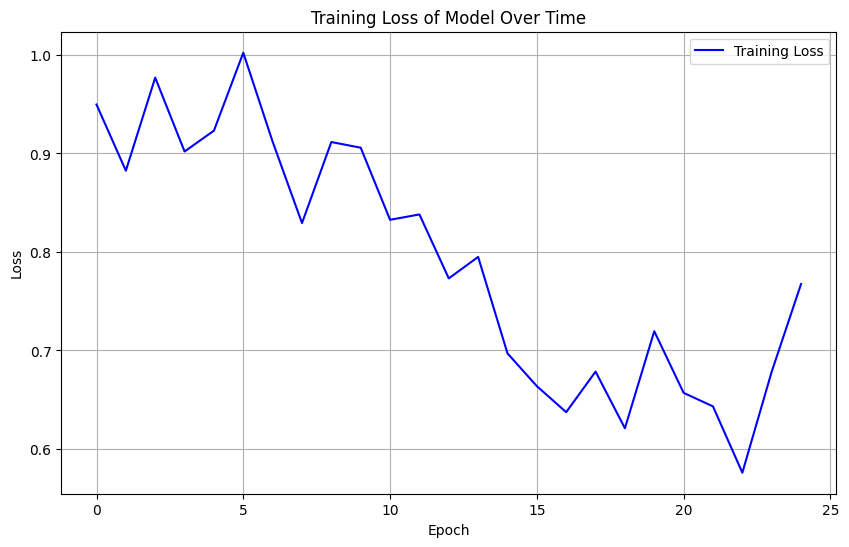

In [18]:
# lossesOverSteps = [loss if tf.is_tensor(loss) else loss for loss in lossesOverSteps]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(range(len(lossesOverSteps)), lossesOverSteps, 'b-', label='Training Loss')  # 'b-' means blue line

# Customize the plot
plt.title('Training Loss of Model Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

Forecasting

In [8]:
# from keras.models import load_model
# model = load_model('imputationModel.h5')

In [20]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed
# from tensorflow.keras.models import Model

In [51]:
# inputs = tf.keras.Input(shape=(961, 7))

# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(inputs)

# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)

# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)

# ld_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, name='ld'))(x)

# state_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax', name='state'))(x)

# a_model = tf.keras.Model(inputs=inputs, outputs=[ld_output, state_output])

In [7]:
# plot_model(a_model, show_shapes=True, show_layer_names=True)

In [53]:
# # Get the output of the last LSTM layer (index 3, assuming layers are: Input, BiLSTM1, BiLSTM2, BiLSTM3)
# encoder_output = model.layers[3].output
# encoder_model = tf.keras.Model(inputs=model.input, outputs=encoder_output)

# # Freeze the encoder layers to preserve trained weights
# for layer in encoder_model.layers:
#     layer.trainable = False

In [54]:
# encoder_input = tf.keras.Input(shape=(961, 7), name='encoder_input')
# decoder_input = tf.keras.Input(shape=(100, 4), name='decoder_input')  # 4 = LD (1) + STATE one-hot (3)

# # Encoder: process past sequence
# encoder_hidden = encoder_model(encoder_input)  # Shape: (None, 861, 32)

# # Decoder: LSTM with attention
# decoder_lstm = tf.keras.layers.LSTM(32, return_sequences=True)(decoder_input)  # Shape: (None, 100, 32)
# context = tf.keras.layers.Attention()([decoder_lstm, encoder_hidden])  # Shape: (None, 100, 32)
# combined = tf.concat([decoder_lstm, context], axis=-1)  # Shape: (None, 100, 64)

# # Output layers
# ld_pred = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, name='ld'))(combined)
# state_pred = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax', name='state'))(combined)

# forecasting_model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=[ld_pred, state_pred])

# forecasting_model.compile(
#     optimizer='adam',
#     loss={'ld': 'mse', 'state': 'sparse_categorical_crossentropy'},
#     loss_weights={'ld': 1.0, 'state': 1.0}
# )

In [6]:
# plot_model(forecasting_model, show_shapes=True, show_layer_names=True)

In [56]:
# train_data = data[:240]
# val_data = data[240:]

# # Past sequences (first 861 timesteps)
# train_past = train_data[:, :861, :]
# val_past = val_data[:, :861, :]

# # Future targets (last 100 timesteps)
# train_target_LD = train_data[:, 861:, 1:2]  # 'LD' is assumed at index 1
# train_target_STATE = train_data[:, 861:, 2:3]  # 'STATE' is assumed at index 2
# val_target_LD = val_data[:, 861:, 1:2]
# val_target_STATE = val_data[:, 861:, 2:3]

# # Decoder input (shifted future sequence with one-hot encoded 'STATE')
# train_STATE_onehot = tf.keras.utils.to_categorical(train_data[:, :, 2], num_classes=3)
# val_STATE_onehot = tf.keras.utils.to_categorical(val_data[:, :, 2], num_classes=3)
# train_decoder_input = tf.concat([train_data[:, 860:960, 1:2], train_STATE_onehot[:, 860:960]], axis=-1)
# val_decoder_input = tf.concat([val_data[:, 860:960, 1:2], val_STATE_onehot[:, 860:960]], axis=-1)

In [5]:
# forecasting_model.fit(
#     [train_past, train_decoder_input],
#     [train_target_LD, train_target_STATE],
#     epochs=10,
#     batch_size=32,
#     validation_data=([val_past, val_decoder_input], [val_target_LD, val_target_STATE])
# )

In [21]:
# inputs = Input(shape=(None, 7))  # Shape: (batch_size, timesteps, features)

# lstm_out = LSTM(64, return_sequences=True)(inputs)  # Shape: (batch_size, timesteps, 64)

# attention = Attention()([lstm_out, lstm_out])  # Query and key are both lstm_out

# context_vector = Concatenate(axis=-1)([lstm_out, attention])

# processed_context = TimeDistributed(Dense(32, activation='relu'))(context_vector)

# ld_output = TimeDistributed(Dense(1, name='ld'))(processed_context)  
# state_output = TimeDistributed(Dense(3, activation='softmax', name='state'))(processed_context)  

# attention_model = Model(inputs=inputs, outputs=[ld_output, state_output])

# # Compile the model
# attention_model.compile(optimizer='adam',
#               loss={'ld': 'mse', 'state': 'sparse_categorical_crossentropy'},
#               metrics={'ld': 'mae', 'state': 'accuracy'})

In [26]:
# plot_model(attention_model, show_shapes=True, show_layer_names=True)

In [4]:
# import tensorflow as tf

# val_flow_true = val_data[:, :, 0:1]  
# val_ld_true = val_data[:, :, 1:2]    
# val_state_true = val_data[:, :, 2:3]  

# val_mask_flow = val_mask[:, :, 0]
# val_mask_ld = val_mask[:, :, 1]
# val_mask_state = val_mask[:, :, 2]

# mse_loss = tf.keras.losses.MeanSquaredError()
# sce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# optimizer = tf.keras.optimizers.Adam()

# @tf.function
# def eval_step(inputs, flow_true, ld_true, state_true, mask_flow, mask_ld, mask_state):
#     with tf.GradientTape() as tape:
#         flow_pred, ld_pred, state_pred = model(inputs)

#         # Note to remember: reduce_sum(...): Sums the masked errors across all elements.
#         flow_loss = tf.reduce_sum(mask_flow * tf.squeeze(tf.square(flow_true - flow_pred))) / tf.reduce_sum(mask_flow)
#         ld_loss = tf.reduce_sum(mask_ld * tf.squeeze(tf.square(ld_true - ld_pred))) / tf.reduce_sum(mask_ld)
#         state_loss = tf.reduce_sum(mask_state * sce_loss(state_true, state_pred)) / tf.reduce_sum(mask_state)
        
#         total_loss = flow_loss + ld_loss + state_loss
    
#     return total_loss

# batch_size = 1
# val_dataset = tf.data.Dataset.from_tensor_slices(
#     (tf.cast(val_masked, tf.float32), 
#      tf.cast(val_flow_true, tf.float32), 
#      tf.cast(val_ld_true, tf.float32), 
#      tf.cast(val_state_true, tf.float32), 
#      tf.cast(val_mask_flow, tf.float32), 
#      tf.cast(val_mask_ld, tf.float32), 
#      tf.cast(val_mask_state, tf.float32))
# ).shuffle(buffer_size=1).batch(batch_size)

# for epoch in range(100):
#     for batch in val_dataset:
#         loss = train_step(*batch)
#     print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')